In [1]:
# Imports
import Transformer
from tensorflow.keras.optimizers import Adam

from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataStreamPreprocessor import DataStream, LastDimensionNormalizer, Batcher
from Quaternion_functions import  mocap_correction, compare_mocap_madgwick, madgwick_turn, finish, transform_matrix
from Quaternion_functions import quaternion_to_euler_angle_vectorized1
import matplotlib.pyplot
import tensorflow as tf
import time
from pyquaternion import Quaternion

tf.random.set_seed(42) 
np.random.seed(42)

import ahrs

In [2]:
#folder = str("../logs/20201002_10_16_28/") # Y up - Stand still
folder_calib = str("../logs/20201002_10_17_42/")  # Y up - Calib for Magneto
folder_test  = str("../logs/20201002_10_19_33/")  # Y up - General Test

#folder_test = str("../logs/20200829_12_37_57/") # 2D yesNoise no Periodic yesRot
#folder_test = str("../logs/20200829_12_05_54/") # 1D yesNoise yesPeriodic no Rot
#folder_test = str("../logs/20201030_11_53_56/") # Egybefüggő teszt, könnyen darabolható
#folder_test = str("../logs/20201002_10_17_42/") # Y up Calib for Magneto
#file = str("../logs/20201002_11_07_24/") # Y up - Training data

d = DataStream(folder_test)
c = DataStream(folder_calib)

d.calibrateMag(c)

In [3]:
'''
folder = str("../logs/20201030_11_53_56/") # Egybefüggő teszt, könnyen darabolható

# load in the full measurement sequence
d = DataStream(folder)

# Slice the second part for Calibration
d_calib = deepcopy(d)
d_calib.keepData(2600, 18500)

# Calibrate the rest of the measurement (Training, Validation and Test set also)
d.calibrateMag(d_calib)

# Add extra features to the collective database here
d.addFeature(['diff_Timestamp'])

# Apply filter for the rest of the measurement (Training, Validation and Test set also)
d.filterData(31, 'bartlett', [1, 2, 3]) # filter Acc
d.filterData(31, 'bartlett', [4, 5, 6]) # filter Gyro
d.filterData(31, 'bartlett', [7, 8, 9]) # filter Mag

# Slice the first part for Initialization (Calculate the Rotation Qoaternion betwwen MoCap and Sensor coordinate system)
d_stand = deepcopy(d)
d_stand.keepData(0,500)

#d.calibMadgwick(d_stand, axis='MOC')

# Slice the third part of the measurement for Training dataset
d_train = deepcopy(d)
d_train.keepData(18600, 42100)
d_train.calcMadgwick()
# If further filtering is needed apply here for only on Training data

# Slice the fourth part of the measurement for Validation dataset
d_valid = deepcopy(d)
d_valid.keepData(43000, 51000)
d_valid.calcMadgwick()
# If further filtering is needed apply here for only on Validation data

# Slice the fifth part of the measurement for Test dataset
d_test = deepcopy(d)
d_test.keepData(51500, 61720)
d_test.calcMadgwick() # bele rakja a sima ahrs-sel számolt madgwickot az adatsorba
# If further filtering is needed apply here for only on Test data
'''

'\nfolder = str("../logs/20201030_11_53_56/") # Egybefüggő teszt, könnyen darabolható\n\n# load in the full measurement sequence\nd = DataStream(folder)\n\n# Slice the second part for Calibration\nd_calib = deepcopy(d)\nd_calib.keepData(2600, 18500)\n\n# Calibrate the rest of the measurement (Training, Validation and Test set also)\nd.calibrateMag(d_calib)\n\n# Add extra features to the collective database here\nd.addFeature([\'diff_Timestamp\'])\n\n# Apply filter for the rest of the measurement (Training, Validation and Test set also)\nd.filterData(31, \'bartlett\', [1, 2, 3]) # filter Acc\nd.filterData(31, \'bartlett\', [4, 5, 6]) # filter Gyro\nd.filterData(31, \'bartlett\', [7, 8, 9]) # filter Mag\n\n# Slice the first part for Initialization (Calculate the Rotation Qoaternion betwwen MoCap and Sensor coordinate system)\nd_stand = deepcopy(d)\nd_stand.keepData(0,500)\n\n#d.calibMadgwick(d_stand, axis=\'MOC\')\n\n# Slice the third part of the measurement for Training dataset\nd_train

In [4]:
#compare_mocap_madgwick(datastream,  plot_start, plot_end, fast_conv = 60, firstq = 100, base='mocap', mode='MARG')
#return: Q, Mocap, moc, mad
# madgwick generation and basic comparison

#transform_matrix(Q, MocapQ, moc, mad,  plot_start, plot_end, f, s, t, base='mocap', mode='MARG')
#return: Q, Mocap
# if we use a marg sensor a trnasformation matrix is useful to make the final comparison between the madgwick and the mocap

#madgwick_turn(Q, array)
#retuen: Q
#finish(Q, MocapQ, moc, mad, base='mocap', mode='MARG')
#return: Q, MocapQ
# if we use a IMU sensor this method could prove better

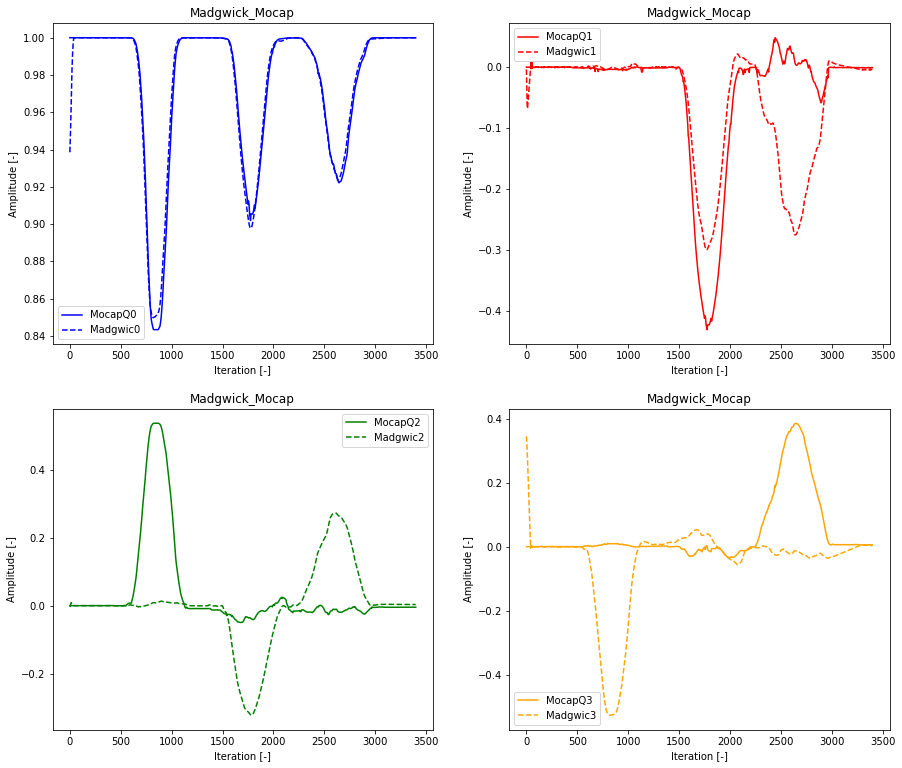

In [5]:
Q, MocapQ, moc, mad =  compare_mocap_madgwick(d,0,3400, fast_conv = 60, firstq = 100, mode = 'MARG',base='mocap')

first step: generation and starting point
help, to determine f s t
[[0.642006550147932 0.699933604701307 0.0186856471979412]
 [0.0619739705939511 -0.0654208694950389 -1.02518848080511]
 [-0.711857620438693 0.693947250716845 -0.00573727837084628]]


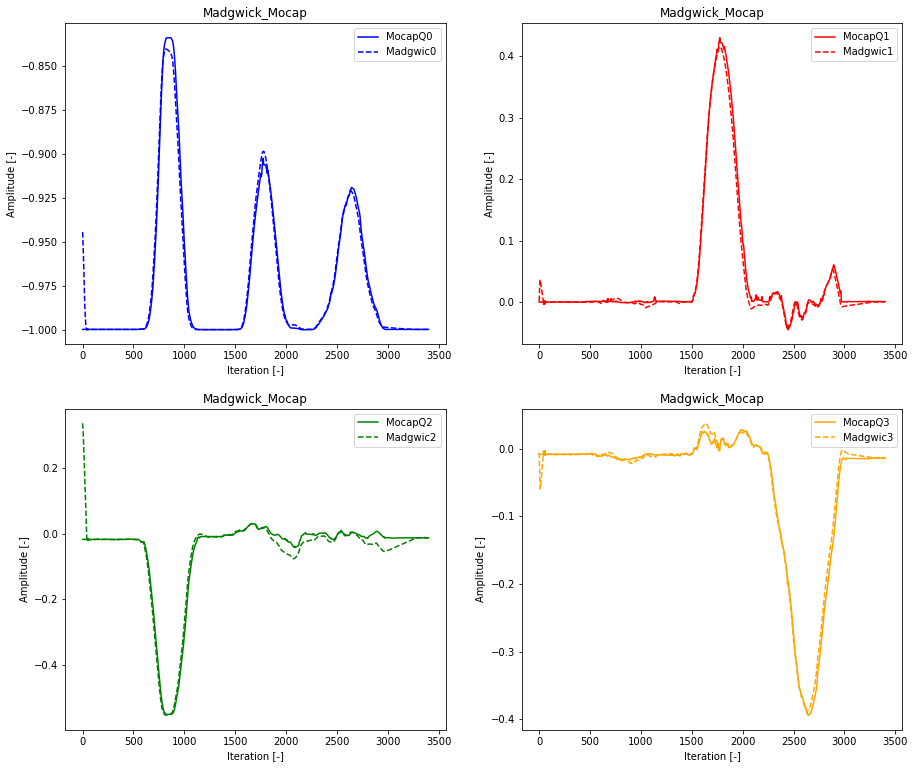

In [6]:
newQ , newMocapQ = transform_matrix(Q, MocapQ, moc, mad,  0, 3400, 855, 1755, 2600, base='mocap', mode='MARG')

In [ ]:
Q = madgwick_turn(Q, [2,-3,-1])

In [ ]:
plot_start = 0
plot_end = 3400

plt.figure(3, figsize=(15, 13))
plt.subplot(221)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ[plot_start:plot_end,0], color='blue', label='MocapQ0')
plt.plot(Q[plot_start:plot_end,0], color='blue', label='Madgwic0',linestyle= '--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()

plt.subplot(222)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ[plot_start:plot_end,1], color='red', label='MocapQ1')
plt.plot(Q[plot_start:plot_end,1], color='red', label='Madgwic1',linestyle='--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
    
plt.subplot(223)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ[plot_start:plot_end,2], color='green', label='MocapQ2')
plt.plot(Q[plot_start:plot_end,2], color='green', label='Madgwic2',linestyle= '--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
    
plt.subplot(224)
plt.title("Madgwick_Mocap")
plt.plot(MocapQ[plot_start:plot_end,3], color='orange', label='MocapQ3')
plt.plot(Q[plot_start:plot_end,3], color='orange', label='Madgwic3',linestyle= '--')
plt.xlabel('Iteration [-]')
plt.ylabel('Amplitude [-]')
plt.legend()
    
    
plt.show()